In [1]:
from PIL import Image
import numpy as np
import os
import cv2
import keras
from keras.utils import np_utils
from imblearn.over_sampling import SMOTE
from keras.preprocessing.image import ImageDataGenerator 
import tensorflow.keras.layers as Layers
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizers
import sklearn.utils as shuffle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Flatten, LeakyReLU, BatchNormalization, Dropout, Input
import tensorflow as tf

# Data Loading

In [2]:
Images = []
Labels = []
Parasitized = os.listdir("../input/chest-xray-pneumonia/chest_xray/train/NORMAL/")
for p in Parasitized:
    try:
        image = cv2.imread("../input/chest-xray-pneumonia/chest_xray/train/NORMAL/" + p)
        images = Image.fromarray(image, 'RGB')
        images = images.resize((150,150))
        Images.append(np.array(images))
        Labels.append(0)
    except AttributeError:
        print('')
Uninfected = os.listdir("../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/")
for u in Uninfected:
    try:
        image = cv2.imread("../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/" + u)
        images = Image.fromarray(image, 'RGB')
        images = images.resize((150,150))
        Images.append(np.array(images))
        Labels.append(1)
    except AttributeError:
        print('')

In [3]:
Images = np.array(Images)
Labels = np.array(Labels)   

In [4]:
print(Images.shape)
print(Labels.shape)

(5216, 150, 150, 3)
(5216,)


In [5]:
def show_images(image, label):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle('25 Images from the dataset' ,fontsize = 20)
    for i in range(25):
        index = np.random.randint(Images.shape[0])
        plt.subplot(5,5,i+1)
        plt.imshow(image[index])
        plt.xticks([]) #Scale doesn't appear
        plt.yticks([]) #Scale doesn't apper
        plt.title((label[index]))
        plt.grid(False)
    plt.show()

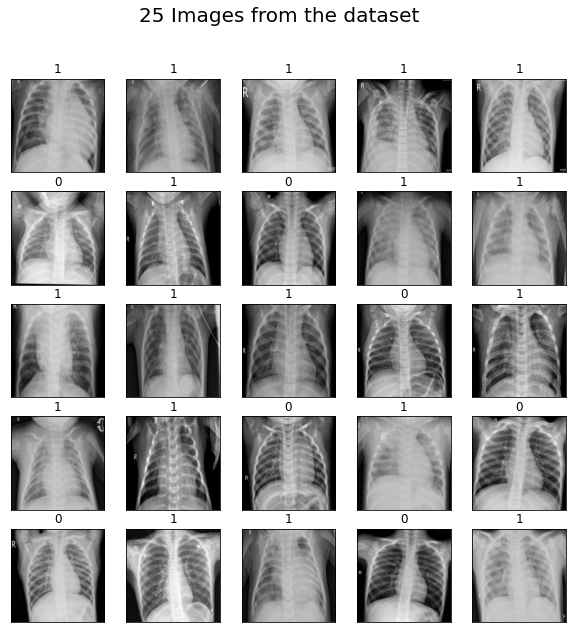

In [6]:
show_images(Images, Labels)

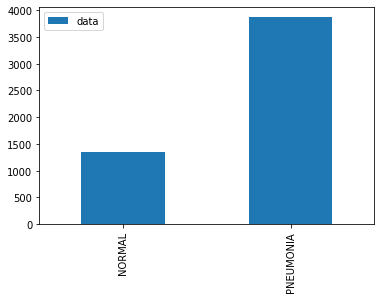

In [7]:
category = ['NORMAL', 'PNEUMONIA']
_,count = np.unique(Labels, return_counts = True)
pd.DataFrame({'data': count}, index = category).plot.bar()
plt.show()

Imbalance class problem would have to solve it using Image Augumentation.

In [8]:
Labels = keras.utils.to_categorical(Labels, 2)

# Model Building

In [9]:
model = Models.Sequential()
model.add(Layers.Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (150,150,3)))
model.add(Layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(Layers.MaxPool2D(3,3))
model.add(Layers.Dropout(0.2))
model.add(Layers.Conv2D(64, kernel_size = (3,3) , activation = 'relu'))
model.add(Layers.Conv2D(64, kernel_size = (3,3) , activation = 'relu'))
model.add(Layers.MaxPool2D(3,3))
model.add(Layers.Conv2D(64, kernel_size = (3,3) , activation = 'relu'))
model.add(Layers.Conv2D(64, kernel_size = (3,3) , activation = 'relu'))
model.add(Layers.MaxPool2D(3,3))
model.add(Layers.Flatten())
model.add(Layers.Dense(512, activation = 'relu'))
model.add(Layers.Dense(256, activation = 'relu'))
model.add(Layers.Dropout(0.2))
model.add(Layers.Dense(2, activation = 'softmax'))
model.compile(optimizer = Optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0

In [10]:
trained = model.fit(Images,Labels,epochs=30,validation_split=0.30)

Epoch 1/30
115/115 [==============================] - 49s 370ms/step - loss: 1.0437 - accuracy: 0.6728 - val_loss: 0.3350 - val_accuracy: 0.9450
Epoch 2/30
115/115 [==============================] - 40s 350ms/step - loss: 0.4009 - accuracy: 0.8279 - val_loss: 0.2989 - val_accuracy: 0.8939
Epoch 3/30
115/115 [==============================] - 40s 350ms/step - loss: 0.2627 - accuracy: 0.8931 - val_loss: 0.0758 - val_accuracy: 0.9879
Epoch 4/30
115/115 [==============================] - 40s 350ms/step - loss: 0.2136 - accuracy: 0.9148 - val_loss: 0.3677 - val_accuracy: 0.8460
Epoch 5/30
115/115 [==============================] - 40s 350ms/step - loss: 0.1923 - accuracy: 0.9334 - val_loss: 0.2130 - val_accuracy: 0.9195
Epoch 6/30
115/115 [==============================] - 40s 350ms/step - loss: 0.1498 - accuracy: 0.9431 - val_loss: 0.3427 - val_accuracy: 0.8677
Epoch 7/30
115/115 [==============================] - 40s 350ms/step - loss: 0.1216 - accuracy: 0.9537 - val_loss: 0.0866 - val_ac

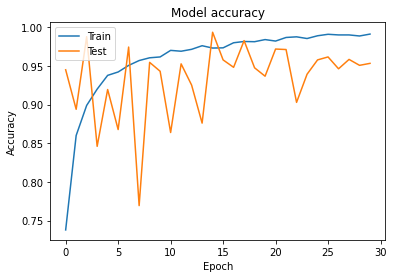

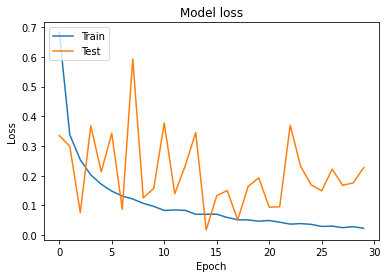

In [11]:
plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
train_generator = ImageDataGenerator(rescale = 1/255, zoom_range = 0.3, horizontal_flip = True, rotation_range = 30)
train_generator = train_generator.flow(Images, Labels, batch_size = 64, shuffle = False)

In [13]:
history = model.fit_generator(train_generator, epochs = 30, shuffle = False)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
82/82 [==============================] - 46s 509ms/step - loss: 0.3688 - accuracy: 0.7627
Epoch 2/30
82/82 [==============================] - 42s 505ms/step - loss: 0.4249 - accuracy: 0.8788
Epoch 3/30
82/82 [==============================] - 42s 505ms/step - loss: 0.2694 - accuracy: 0.9440
Epoch 4/30
82/82 [==============================] - 42s 509ms/step - loss: 0.2262 - accuracy: 0.9572
Epoch 5/30
82/82 [==============================] - 42s 506ms/step - loss: 0.2068 - accuracy: 0.9605
Epoch 6/30
82/82 [==============================] - 42s 506ms/step - loss: 0.1916 - accuracy: 0.9617
Epoch 7/30
82/82 [==============================] - 42s 507ms/step - loss: 0.1896 - accuracy: 0.9634
Epoch 8/30
82/82 [==============================] - 42s 507ms/step - loss: 0.1854 - accuracy: 0.9636
Epoch 9/30
82/82 [==============================] - 42s 506ms/step - loss: 0.1851 - accuracy: 0.9653
Epoch 10/30
82/82 [==============================] - 42s 505ms/step - loss: 0.1717 - accura

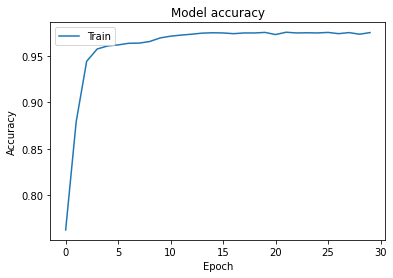

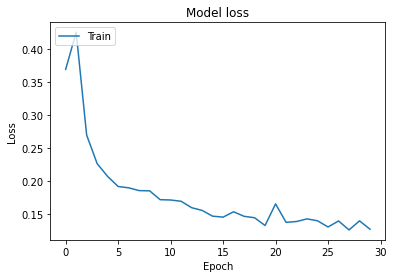

In [14]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [15]:
Val_Images = []
Val_Labels = []
Parasitized = os.listdir("../input/chest-xray-pneumonia/chest_xray/val/NORMAL/")
for p in Parasitized:
    try:
        image = cv2.imread("../input/chest-xray-pneumonia/chest_xray/val/NORMAL/" + p)
        images = Image.fromarray(image, 'RGB')
        images = images.resize((150,150))
        Val_Images.append(np.array(images))
        Val_Labels.append(0)
    except AttributeError:
        print('')
Uninfected = os.listdir("../input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/")
for u in Uninfected:
    try:
        image = cv2.imread("../input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/" + u)
        images = Image.fromarray(image, 'RGB')
        images = images.resize((150,150))
        Val_Images.append(np.array(images))
        Val_Labels.append(1)
    except AttributeError:
        print('')

In [16]:
Val_Images = np.array(Val_Images)
Val_Labels = np.array(Val_Labels)

In [17]:
print(Val_Images.shape)
print(Val_Labels.shape)

(16, 150, 150, 3)
(16,)


In [18]:
Val_Labels = keras.utils.to_categorical(Val_Labels, 2)

In [19]:
test_generator = ImageDataGenerator(rescale = 1/255)
test_generator = test_generator.flow(Val_Images, Val_Labels, batch_size = 64, shuffle = False)

In [20]:
evaluate = model.evaluate(Val_Images, Val_Labels, verbose = 1)

1/1 [==============================] - 1s 943ms/step - loss: 785.5186 - accuracy: 0.5000


In [21]:
print( "Accuracy: "  + str(evaluate[1] * 100) + "%")

Accuracy: 50.0%


In [22]:
evaluate2 = model.evaluate_generator(test_generator, verbose = 10)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [23]:
print( "Accuracy: "  + str(evaluate2[1] * 100) + "%")

Accuracy: 50.0%


In [24]:
train_datagen=ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=7,
    width_shift_range=0.5,
    height_shift_range=0.45,
    shear_range=0.2,
    zoom_range=0.45,
    horizontal_flip=True
    
)
test_datagen=ImageDataGenerator(
    rescale=1/255.0
)

In [25]:
train_set=train_datagen.flow_from_directory('../input/chest-xray-pneumonia/chest_xray/train/',
                                                 target_size=(150, 150),
                                                 batch_size=32,
                                                 shuffle=True,
                                                 class_mode='binary')

Found 5216 images belonging to 2 classes.


In [26]:
val_set=test_datagen.flow_from_directory('../input/chest-xray-pneumonia/chest_xray/val/',
                                         target_size=(150,150),
                                         batch_size=32,
                                         class_mode='binary'
                                        )

Found 16 images belonging to 2 classes.


In [27]:
inception=tf.keras.applications.inception_v3.InceptionV3(include_top=False,input_shape=(150,150,3),weights='imagenet')
layer=inception.get_layer('mixed7')
x=tf.keras.layers.Flatten()(layer.output)
x=tf.keras.layers.Dense(units=1024,activation='relu')(x)
x=tf.keras.layers.Dense(units=512,activation='relu')(x)
x=tf.keras.layers.Dense(1)(x)
out=tf.keras.layers.Activation(activation='sigmoid')(x)
model=tf.keras.Model(inputs=inception.input,outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),loss='binary_crossentropy',metrics=['accuracy','mae'])


87916544/87910968 [==============================] - 1s 0us/step


In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [29]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [30]:
my_callback = MyThresholdCallback(threshold=0.93)
history = model.fit_generator(train_set,
                    epochs=30,
                    validation_data=val_set,
                    callbacks=[my_callback]
                    )

Epoch 1/30
163/163 [==============================] - 86s 477ms/step - loss: 0.3612 - accuracy: 0.8341 - mae: 0.2061 - val_loss: 3.7584 - val_accuracy: 0.7500 - val_mae: 0.2740
Epoch 2/30
163/163 [==============================] - 77s 475ms/step - loss: 0.1582 - accuracy: 0.9454 - mae: 0.0757 - val_loss: 0.7801 - val_accuracy: 0.8750 - val_mae: 0.1410
Epoch 3/30
163/163 [==============================] - 78s 477ms/step - loss: 0.1390 - accuracy: 0.9483 - mae: 0.0749 - val_loss: 0.6195 - val_accuracy: 0.8750 - val_mae: 0.1242
Epoch 4/30
163/163 [==============================] - 77s 469ms/step - loss: 0.1282 - accuracy: 0.9544 - mae: 0.0678 - val_loss: 0.1869 - val_accuracy: 0.8750 - val_mae: 0.0954
Epoch 5/30
163/163 [==============================] - 77s 473ms/step - loss: 0.1253 - accuracy: 0.9509 - mae: 0.0651 - val_loss: 0.3848 - val_accuracy: 0.7500 - val_mae: 0.1803
Epoch 6/30
163/163 [==============================] - 79s 482ms/step - loss: 0.1077 - accuracy: 0.9621 - mae: 0.056

In [31]:
test_set=test_datagen.flow_from_directory('../input/chest-xray-pneumonia/chest_xray/test/',
                                          target_size=(150,150),
                                          batch_size=1,
                                          class_mode='binary',
                                          shuffle=False
)

Found 624 images belonging to 2 classes.


In [32]:
predict=model.evaluate(test_set)

624/624 [==============================] - 11s 18ms/step - loss: 2.5393 - accuracy: 0.9119 - mae: 0.0894


In [33]:
print( "Accuracy: "  + str(predict[1] * 100) + "%")

Accuracy: 91.18589758872986%
